In [26]:
import torch
import numpy as np
import os

from torchvision import datasets
from torchvision import transforms
import torchvision.transforms as T

import matplotlib.pyplot as plt
import pandas as pd

from numpy import genfromtxt

from PIL import Image

import random

# import visiondataset
from torchvision.datasets import VisionDataset
import pandas as pd

## Dataset

In [27]:
import pickle
from typing import Any, Callable, Dict, List, Optional, Tuple, Union

class MyDataset(VisionDataset):
    classes = [
        'sword',
        'pickaxe',
        'axe',
        'hoe',
        'shovel'
    ]

    def __init__(
        self,
        root: str = ".",
        train: bool = True,
        transform: Optional[Callable] = None,
        target_transform: Optional[Callable] = None,
    ) -> None:
        super().__init__(root, transform=transform, target_transform=target_transform)
        self.train = train  # training set or test set

        self.ids, self.data, self.features = self._load_data(root)

    def __getitem__(self, index: int) -> Tuple[Any, Any]:
        """
        Args:
            index (int): Index

        Returns:
            tuple: (image, target) where target is index of the target class.
        """
        id = self.ids[index]
        img = self.data[index]
        features = self.features[index]
        id, img, features = self.ids[index], self.data[index], self.features[index]

        # doing this so that it is consistent with all other datasets
        # to return a PIL Image
        # img = Image.fromarray(img.numpy().astype(np.uint8))

        if self.transform is not None:
            img = self.transform(img)

        if self.target_transform is not None:
            target = self.target_transform(target)

        return id, img, features

    def __len__(self) -> int:
        return len(self.data)
    
    def _load_data(self, root: str):
        ids = pd.read_csv(f'{root}/PD_ids_train.csv')
        data = pd.read_csv(f'{root}/PD_imgs_np_train.csv')
        features = pd.read_csv(f'{root}/PD_conditions_train.csv')

        # convert all to list
        ids = ids.values.tolist()
        data = data.values.tolist()
        features = features.values.tolist()

        return ids, data, features # TODO something better than a list


id: [0, 'tg_Ng150_Pci0_H0_Wp0_Ph500_Ox24_Ow8.0_Hbt1459.8_Wm12.2_Wr308750.4.jpg']
data: [0, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 254, 166, 132, 134, 132, 128, 124, 120, 116, 112, 108, 105, 102, 100, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 188, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 107, 47, 51, 47, 41, 34, 27, 19, 13, 7, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 143, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 114, 57, 60, 56, 51, 43, 36, 28, 22, 15, 9, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 147, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 116, 59, 62, 59, 53, 45, 37, 28, 21, 14, 8, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 147, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 118, 62, 65, 61, 55, 47, 37, 28, 20, 12, 6, 1, 0, 0, 0, 0,

,tg,Ng,Pci,H,Wp,Ph,Ox,Ow,Hbt,Wm,Wr
0,0.0,150.0,0.0,0.0,0.0,500.0,24.0,8.0,1459.8,12.2,308750.4


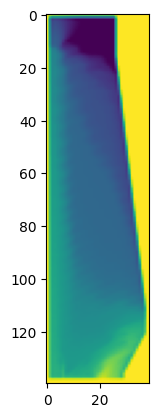

In [55]:
dataset = MyDataset(root='.')
datum = dataset[0]
print(f"""
id: {datum[0]}
data: {datum[1]}
features: {datum[2]}
""")

# convert data to image plot
# TODO first pixel is bad
img = np.array(datum[1][1:])
img = img.reshape(140, 39)
plt.imshow(img)

# convert features to dataframe
# TODO not correct, but ai guessed the labels, so its funny
# Ng = Nitrogen, Pci = Pesticide, H = Humidity, Wp = Watering pattern, Ph = pH, 0x = 0x, 0w = 0w, Hbt = Habitat, Wm = Weed management, Wr = Weather
labels = [ 'tg', 'Ng', 'Pci', 'H', 'Wp', 'Ph', 'Ox', 'Ow', 'Hbt', 'Wm', 'Wr' ]
conditions = np.array(datum[2])
features = pd.DataFrame([conditions], columns=labels)
display(features)

## CGAN